# Dask Machine Learning

- Dask-ML enables scalable machine learning
- It comes with explicit support for certain models such as dask-xgboost
- It supports existing machine learning methods such as scikit-learn, tensorflow, keras, etc. 
- Large Model (Exploit parallelism with delayed executions, Hyperparameter tunning, etc.,)
- Large Data (Dask Collections to manage memory)

#### CPU bound vs MEM bound Machine Learning Models
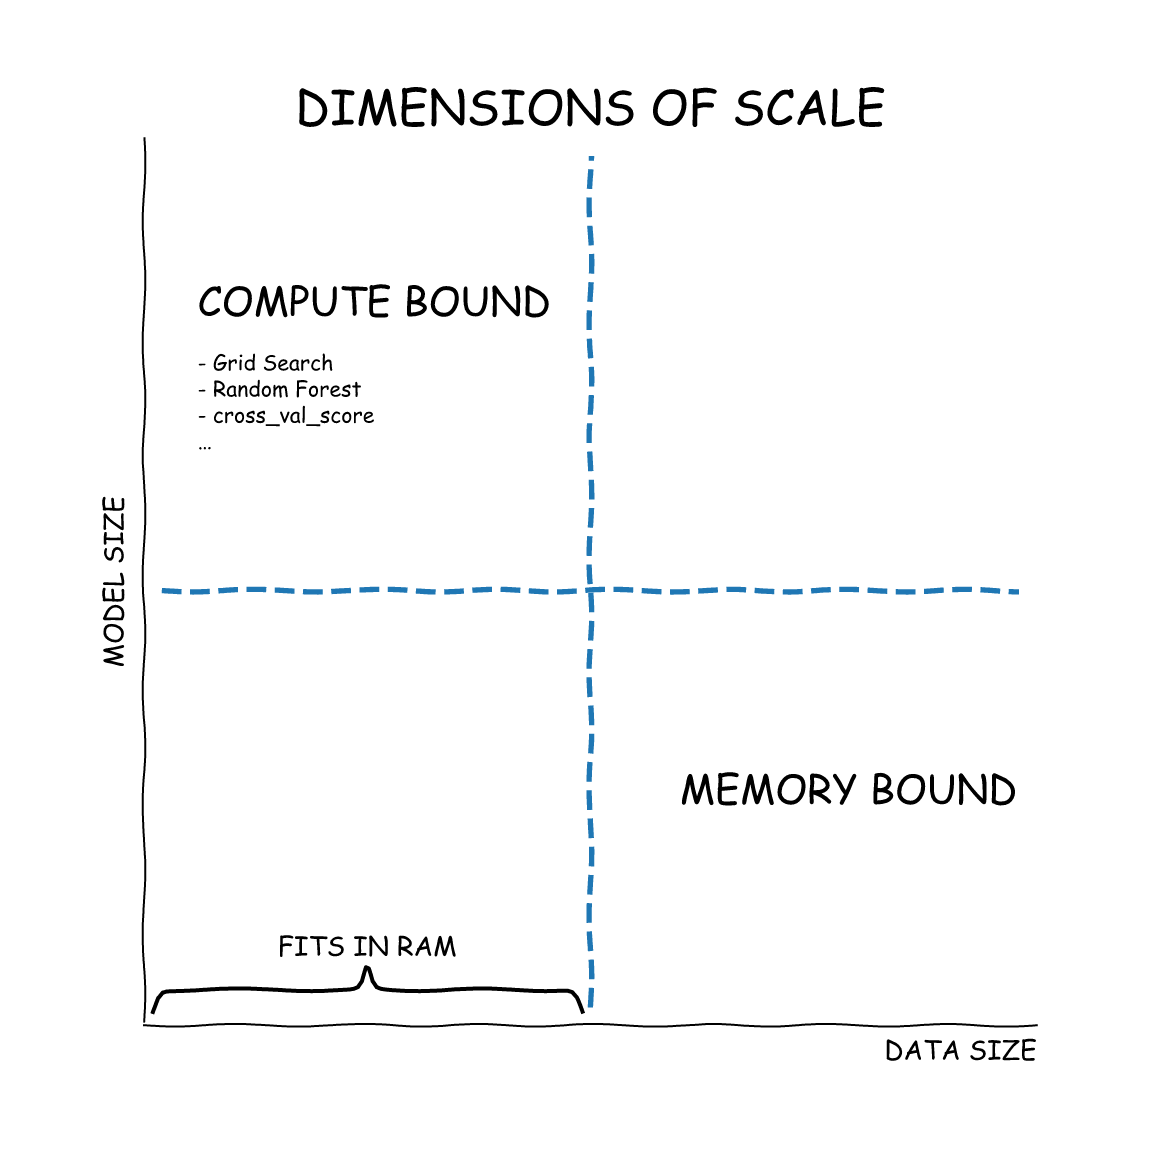


#### Distributed Machine Learning across multiple nodes
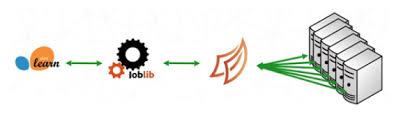

### Compute Bound

- Distribute training and prediction across multiple nodes. 
- Hyperparameter tunning

### Memory Bound 
- Blockwise Ensemble Methods
- Incremental Learning

### Compute and Memory Bound
Re-implemented Models like dask-xgboost and dask-knn are efficeint with both CPU and Memor intensive computations. 

In [1]:
# Importing dask 
import dask
import dask.array as da
import dask.dataframe as dd
import dask.delayed as delayed
import dask_ml.datasets
import dask_ml.cluster
import time
%load_ext memory_profiler
dask.__version__

'2.30.0'

## Blockwise Ensemble Methods

- Ensemble methods such as Bagging methods, Forrests of randomized trees, etc., are good for blockwise approaches. 
- Create homogenous data blocks from dask.array or dask.dataframe. 
- Train a copy of the model on each block. 
- At prediction, take an ensemble average of the trainined models. 

In [2]:
# A classification example from dask_ml.datasets
X, y = dask_ml.datasets.make_classification(n_samples=1e4, chunks=1e3, random_state=0)
X

dask.array<normal, shape=(10000, 20), dtype=float64, chunksize=(1000, 20), chunktype=numpy.ndarray>

The sub-estimator should be an instantiated scikit-learn-API compatible estimator (anything that implements the fit / predict API, including pipelines). It only needs to handle in-memory datasets. We’ll use sklearn.linear_model.RandomForestClassifier.

In [3]:
import dask_ml.ensemble
from sklearn.ensemble import RandomForestClassifier
subestimator = RandomForestClassifier(random_state=0)
clf = dask_ml.ensemble.BlockwiseVotingClassifier(
    subestimator,
    classes=[0, 1]
)
clf

BlockwiseVotingClassifier(classes=[0, 1],
                          estimator=RandomForestClassifier(random_state=0))

We can train the esemble of models on data chunks. This will independently fit a clone of subestimator on each partition of X and y.

In [4]:
clf.fit(X, y)

In [5]:
clf.estimators_

[RandomForestClassifier(random_state=0),
 RandomForestClassifier(random_state=0),
 RandomForestClassifier(random_state=0),
 RandomForestClassifier(random_state=0),
 RandomForestClassifier(random_state=0),
 RandomForestClassifier(random_state=0),
 RandomForestClassifier(random_state=0),
 RandomForestClassifier(random_state=0),
 RandomForestClassifier(random_state=0),
 RandomForestClassifier(random_state=0)]

Different estimators were trained on separate batches of data. Each estimator has its own set of parameters. 

In [6]:
preds = clf.predict(X[:20])
preds.compute()

array([1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0])

The prediction calls subestimator.predict(chunk) for each subestimator (20 in our case). These subestimator predictions are averaged at the end. 

The blockwise algorithm was applied to the training and the prediction steps. 

In [7]:
%%time
%memit clf.score(X, y)

peak memory: 227.35 MiB, increment: 4.62 MiB
CPU times: user 7.5 s, sys: 1.35 s, total: 8.85 s
Wall time: 4.75 s


### Predictions on large data sets

In [8]:
#da.concatenate([X, X, X, X])
N = 10
X_large = da.concatenate([ X for _ in range(N)])
y_large = da.concatenate([ y for _ in range(N)])
X_large

dask.array<concatenate, shape=(100000, 20), dtype=float64, chunksize=(1000, 20), chunktype=numpy.ndarray>

In [9]:
X_large.rechunk(10000, 10000)

dask.array<rechunk-merge, shape=(100000, 20), dtype=float64, chunksize=(10000, 20), chunktype=numpy.ndarray>

In [10]:
y_large.rechunk(10000, 10000)

dask.array<rechunk-merge, shape=(100000,), dtype=int64, chunksize=(10000,), chunktype=numpy.ndarray>

In [11]:
clf.score(X_large, y_large)

0.6703

In [12]:
%%time
%memit clf.score(X, y)

peak memory: 234.38 MiB, increment: 0.48 MiB
CPU times: user 7.72 s, sys: 1.31 s, total: 9.03 s
Wall time: 4.98 s


In [13]:
%%time
%memit clf.score(X_large, y_large)

peak memory: 235.88 MiB, increment: 1.50 MiB
CPU times: user 1min 48s, sys: 23.3 s, total: 2min 11s
Wall time: 1min 10s


## Incremental learning

- Some estimators are suitable for incremental training. This is useful for on-line training and as well training of large data sets. 

- Scikit-Learn provides partial_fit function for incremental learning. The partial_fit function works with Stochastic Gradient Descent, K-means, and Passive-Aggresive, and Naive Bayes based ML methods. 

- dask_ml.wrappers.Incremental acts as a bridge between Dask and Scikit-Learn estimators supporting the partial_fit API. 


In [14]:
from dask_ml.wrappers import Incremental
from sklearn.linear_model import SGDClassifier

In [15]:
X, y = dask_ml.datasets.make_classification(n_samples=10000, chunks=1000, random_state=0)
X

dask.array<normal, shape=(10000, 20), dtype=float64, chunksize=(1000, 20), chunktype=numpy.ndarray>

In [16]:
estimator = SGDClassifier(random_state=10, max_iter=100)
clf = Incremental(estimator)
clf.fit(X, y, classes=[0, 1])

Incremental(estimator=SGDClassifier(max_iter=100, random_state=10))

As usual with Dask-ML, scoring is done in parallel (and distributed on a cluster if you’re connected to one).

In [17]:
clf.score(X, y)

0.5701

## Hyper parameter Search -  Support Vector Classifier (CPU Bound)

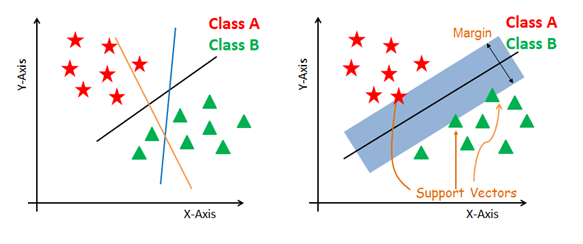

In [18]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd
import joblib

In [19]:
from dask.distributed import Client, LocalCluster
client = Client(n_workers=8, threads_per_worker=8, memory_limit='4GB')
client 

Client Scheduler: tcp://127.0.0.1:46003 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 64 Memory: 32.00 GB


In [20]:
X, y = make_classification(n_samples=1000, random_state=0)
X[:2]

array([[-1.06377997,  0.67640868,  1.06935647, -0.21758002,  0.46021477,
        -0.39916689, -0.07918751,  1.20938491, -0.78531472, -0.17218611,
        -1.08535744, -0.99311895,  0.30693511,  0.06405769, -1.0542328 ,
        -0.52749607, -0.0741832 , -0.35562842,  1.05721416, -0.90259159],
       [ 0.0708476 , -1.69528125,  2.44944917, -0.5304942 , -0.93296221,
         2.86520354,  2.43572851, -1.61850016,  1.30071691,  0.34840246,
         0.54493439,  0.22532411,  0.60556322, -0.19210097, -0.06802699,
         0.9716812 , -1.79204799,  0.01708348, -0.37566904, -0.62323644]])

In [21]:
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           iid=True, n_jobs=-1,
                           cv=3)
                           

In [22]:
%%time
grid_search.fit(X, y)

CPU times: user 510 ms, sys: 625 ms, total: 1.13 s
Wall time: 3.32 s


/projects/community/py-bigdata/2020/bd387/envs/dask-ml/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=SVC(gamma='auto', probability=True, random_state=0),
             iid=True, n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'shrinking': [True, False]})

In [ ]:
%%time
with joblib.parallel_backend('dask'):
    grid_search.fit(X, y)

In [26]:
grid_search.score(X, y)

0.972

In [ ]:
client.shutdown()

## Summary
- Deploy dask-ml and dask collections to manage large data for the machine learning
- Hyperparameter training of models can be accomplished by distributing the jobs on multiple machines